# Introduction
The following is a case study based on an example from the [Analytics Vidhya DataHack platform](https://datahack.analyticsvidhya.com) and involves a fictional company, Dream Housing Finance company. This company deals in all home loans. They have a presence across all urban, semi-urban and rural areas. Customers first apply for a home loan and after that, Dream Housing Finance company validates the customer's eligibility. The company wants to automate the loan eligibility process in real-time, based on customer detail provided while filling online application form.

# Downloading and Exploring the Data
To start, we load the training and testing set into your python environment. We will use the [training](https://s3-ap-southeast-1.amazonaws.com/av-datahack-datacamp/train.csv) set to build our model, and the [test](https://s3-ap-southeast-1.amazonaws.com/av-datahack-datacamp/test.csv) set to validate it. Both the files are stored on the web as CSV files. We will load this data with the `pandas.read_csv()` function. It converts the data set to a python dataframe. In simple words, Python dataframe can be imagined as an equivalent of a spreadsheet or a SQL table.

In [1]:
# Import necesary libraries and remove warnings
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from __future__ import division
import numpy as np
import pandas as pd

# Import training data as train
train = pd.read_csv("https://s3-ap-southeast-1.amazonaws.com/av-datahack-datacamp/train.csv")

# Import testing data as test
test = pd.read_csv("https://s3-ap-southeast-1.amazonaws.com/av-datahack-datacamp/test.csv")

# Print top 5 observation of training dataset
print "Top 5 observations in the training dataset:", "\n", "\n", train.head()

# Print the dimensions of the training dataset
print "Number of observations in the training dataset:", len(train)
print "Number of variables in the training dataset:", len(train.columns)

Top 5 observations in the training dataset: 

    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                  0         NaN               360   
1             4583               1508         128               360   
2             3000                  0          66               360   
3             2583               2358         120               360   
4             6000                  0         141               360   

   Credit_History Property_Area Loan_Status  
0               1         Urban           Y  
1               1   

### Summary Statistics
Additionally we can do some summary statistics, usig the `dataframe.describe()` function, on the __numerical__ values of the training dataset. This will show us the *count*, *mean*, *standard deviation (sd)*, *min*, *quartiles* and max in its output.

In [2]:
# Look at the summary statistics of the numerical variables
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


For the __non-numeric__ (catagorical) values like `Property_Area`, `Credit_History` etc., we can look at frequency distribution. 

In [3]:
# Frequency distribution for `Property_Area`
train['Property_Area'].value_counts()

Semiurban    233
Urban        202
Rural        179
dtype: int64

In [4]:
# Frequency distribution for `Credit_History`
train['Credit_History'].value_counts()

1    475
0     89
dtype: int64

### Numerical Value Distribution
Now that we are familiar with basic data characteristics, we next look at the distribution of numerical variables. We start by plotting the histogram of `LoanAmount` and `ApplicantIncome` variables.

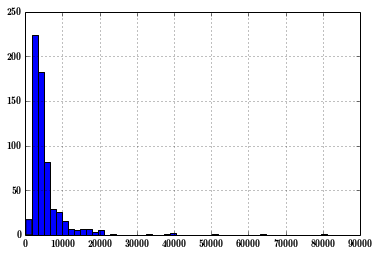

In [5]:
# Plot histogram for variable LoanAmount
train['ApplicantIncome'].hist(bins = 50)

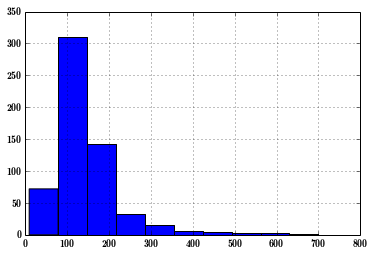

In [6]:
# Plot histogram for variable LoanAmount
train['LoanAmount'].hist()

We can further explore the `LoanAmount` distribution by breaking it down further based on the `Gender` catagory.

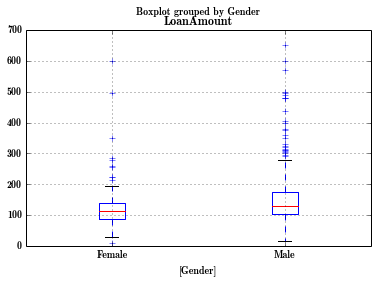

In [7]:
# Plot a box plot for variable LoanAmount by variable Gender of training data set
train.boxplot(column='LoanAmount', by = 'Gender')

### Catagorical Variable Distribution
We have looked at an example of the __numerical__ distributions of `ApplicantIncome` and `LoanIncome` and an example of how an applicants *Gender* may impact the decision. The above plot highlights that the distribution between Males and Females and the Loan Amount is not exactly alligned. This warrants further exploration, for instance, we can try see whether `Gender` is affecting the loan status or not. This can be tested using cross-tabulation, using the `crosstab()` function.

In [8]:
# Create a crosstab of `Gender` and `Loan_Status`
pd.crosstab(train['Gender'], train['Loan_Status'], margins = True)

Loan_Status,N,Y,All
Gender,,,
Female,37,75,112
Male,150,339,489
All,192,422,614


At first glance, it would seem that there are more loans approved for Males as opposed to Females, $339$ vs. $75$. But if we look closer, there are also more Male applicants than Female applications. So let's try and understand this within the context of proportions, using the `apply()` function.

In [9]:
# Define a function to convert to percentages
def percentages(x):
  return x/float(x[-1])

# Create a crosstab of `Gender~ and `Loan_status` and `apply` the above function 
pd.crosstab(train ["Gender"], train ["Loan_Status"], margins = True).apply(percentages, axis = 1)

Loan_Status,N,Y,All
Gender,,,
Female,0.330357,0.669643,1
Male,0.306748,0.693252,1
All,0.312704,0.687296,1


By looking at the proportions, we can see there is in fact no Gender discrimination as the amount of loan application approvals (as well as loan aplication rejections) between Males and Females are fairly equal. 

So from a data exploration exercise, it seems that we have an even distribution of data (both numerical and catagorical) in order to proceed.

# Cleaning the Data
Rarely is the data captured perfectly, and especially in the process of applying for a Home Loan, people may not disclose all details or the data may not be entered correctly. So the next task is look of potential missing values using the `isnull()` function.

In [10]:
# Look for missing values
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

So even though there are missing values in the dataset, not all of them impact wether or not a loan application is approved, however variables like `LoanAmount` are import. So the next step is to impute the missing values in the important variables.

There are multiple ways to fill the missing values of continuous variables. You can replace them with mean, median or estimate values based on other features of the data set. For the sake of simplicity, we would impute the missing values of `LoanAmount` by the __mean__ of the values for `LoanAmount` using the `fillna()` function. 

In [11]:
# Calculate the mean of the values for `LoanAmount`
print "Mean of the values for LoanAmount:", round(train['LoanAmount'].mean())

# Impute the missing values with the mean
train['LoanAmount'].fillna(train['LoanAmount'].mean(), inplace = True)

# Confirm no missing values
print "\n", "Does LoanAmount have missing values?", "\n", train['LoanAmount'].isnull().sum() > 0

Mean of the values for LoanAmount: 146.0

Does LoanAmount have missing values? 
False


But what about catagorical variables, like `Self_Employed`? To impute missing values of Categorical variables, we look at the frequency table. The simplest way is to impute with value which has highest frequency because there is a higher probability of success.

In [19]:
# Print the distribution of variabes
print train['Self_Employed'].value_counts()

# Print the percentage of 'No'
print "\n", "Precentage of No's:", \
round(train['Self_Employed'].value_counts()['No']/train['Self_Employed'].value_counts().sum() * 100, 2)

No     500
Yes     82
dtype: int64

Precentage of No's: 85.91


If we look at the distribution of `SelfEmployed`, $500$ out of $582$ which is aproximately $86%$ of total values falls under the category "No". So to impute the missing values in `SelfEmployed`, we will replace missing values with __No__. We will also apply this methadology to other important catagorical variables, `Gender` and `Credit_History`.

In [20]:
# Impute missing catagorical values
train['Self_Employed'].fillna('No', inplace = True)
train['Gender'].fillna('Male', inplace = True)
train['Credit_History'].fillna(1, inplace = True)